# 📘 TensorFlow CIFAR-10: Student & Teacher Models with 5-Layer Unfreeze

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Resizing
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


2025-07-28 11:39:36.510355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 11:39:37.228641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 11:39:37.231949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-28 11:39:38.718151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


### 🧒 Student Model Definition

In [3]:
def create_student_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="Simple_Student_CNN")

student_model = create_student_model()
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
student_model.summary()


Model: "Simple_Student_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 flatten (Flatten)           (None, 8192)       

2025-07-28 11:39:42.892272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: tesla
2025-07-28 11:39:42.892288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: tesla
2025-07-28 11:39:42.892337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-07-28 11:39:42.892365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 575.64.3


### 🧑‍🏫 Teacher Model with 5 Unfrozen Layers

In [4]:
def create_teacher_model(base_model_class, model_name="Teacher", layers_to_unfreeze=5):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=(48, 48, 3))
    base_model.trainable = False
    for layer in base_model.layers[-layers_to_unfreeze:]:
        layer.trainable = True

    inputs = Input(shape=(32, 32, 3))
    x = Resizing(48, 48)(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs, name=model_name)
    return model


### 🎯 Train Student Model

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_student = student_model.fit(
    x_train, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping]
)


Epoch 1/30
313/313 [==============================] - 19s 59ms/step - loss: 1.7880 - accuracy: 0.3577 - val_loss: 1.7752 - val_accuracy: 0.4079
Epoch 2/30
313/313 [==============================] - 16s 51ms/step - loss: 1.4449 - accuracy: 0.4819 - val_loss: 1.3683 - val_accuracy: 0.5352
Epoch 3/30
313/313 [==============================] - 14s 44ms/step - loss: 1.3169 - accuracy: 0.5296 - val_loss: 1.2005 - val_accuracy: 0.5806
Epoch 4/30
313/313 [==============================] - 17s 55ms/step - loss: 1.2237 - accuracy: 0.5640 - val_loss: 1.2228 - val_accuracy: 0.5722
Epoch 5/30
313/313 [==============================] - 16s 52ms/step - loss: 1.1537 - accuracy: 0.5894 - val_loss: 1.0992 - val_accuracy: 0.6140
Epoch 6/30
313/313 [==============================] - 19s 60ms/step - loss: 1.0882 - accuracy: 0.6098 - val_loss: 1.1624 - val_accuracy: 0.6003
Epoch 7/30
313/313 [==============================] - 17s 53ms/step - loss: 1.0478 - accuracy: 0.6266 - val_loss: 1.0960 - val_accuracy:

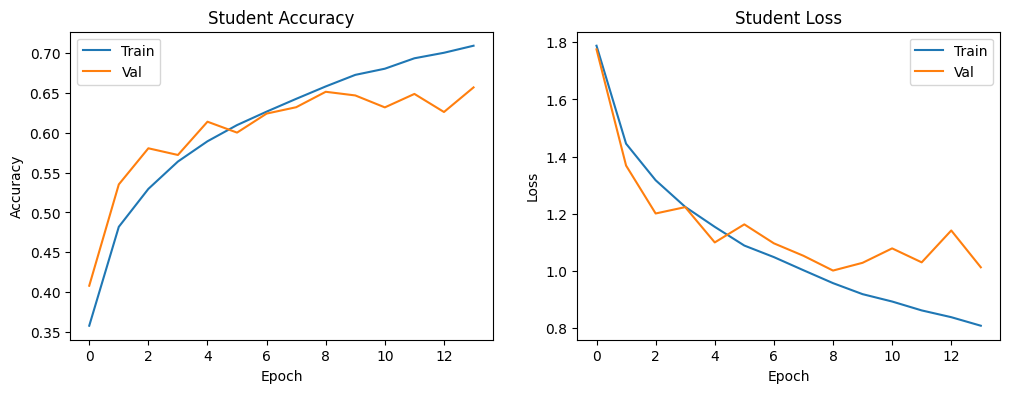

In [6]:
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_student, "Student")


### 🧑‍🏫 Train VGG16 Teacher

Epoch 1/30
313/313 [==============================] - 232s 738ms/step - loss: 2.1105 - accuracy: 0.2439 - val_loss: 1.7477 - val_accuracy: 0.4336
Epoch 2/30
313/313 [==============================] - 235s 750ms/step - loss: 1.7295 - accuracy: 0.4000 - val_loss: 1.5580 - val_accuracy: 0.4872
Epoch 3/30
313/313 [==============================] - 234s 747ms/step - loss: 1.5913 - accuracy: 0.4489 - val_loss: 1.4587 - val_accuracy: 0.5105
Epoch 4/30
313/313 [==============================] - 235s 751ms/step - loss: 1.5119 - accuracy: 0.4787 - val_loss: 1.3979 - val_accuracy: 0.5278
Epoch 5/30
313/313 [==============================] - 308s 983ms/step - loss: 1.4577 - accuracy: 0.4972 - val_loss: 1.3563 - val_accuracy: 0.5391
Epoch 6/30
313/313 [==============================] - 399s 1s/step - loss: 1.4116 - accuracy: 0.5125 - val_loss: 1.3235 - val_accuracy: 0.5473
Epoch 7/30
313/313 [==============================] - 355s 1s/step - loss: 1.3789 - accuracy: 0.5240 - val_loss: 1.2993 - val_a

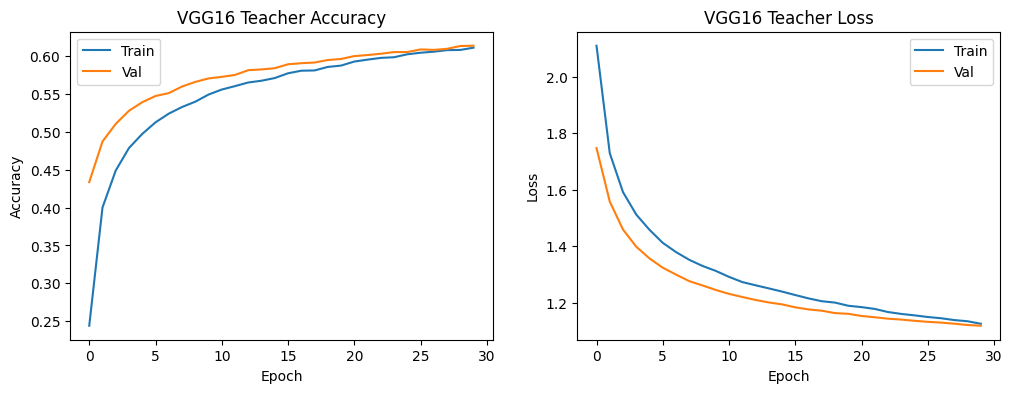

In [7]:
teacher_vgg16 = create_teacher_model(VGG16, model_name="Teacher_VGG16")
teacher_vgg16.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16 = teacher_vgg16.fit(
    x_train, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping]
)

plot_history(history_vgg16, "VGG16 Teacher")


### 🧑‍🏫 Train MobileNetV2 Teacher

Epoch 1/30
313/313 [==============================] - 26s 77ms/step - loss: 2.1444 - accuracy: 0.2929 - val_loss: 1.6723 - val_accuracy: 0.4330
Epoch 2/30
313/313 [==============================] - 24s 76ms/step - loss: 1.6500 - accuracy: 0.4297 - val_loss: 1.5006 - val_accuracy: 0.4941
Epoch 3/30
313/313 [==============================] - 24s 76ms/step - loss: 1.5001 - accuracy: 0.4772 - val_loss: 1.4051 - val_accuracy: 0.5228
Epoch 4/30
313/313 [==============================] - 23s 74ms/step - loss: 1.4139 - accuracy: 0.5113 - val_loss: 1.3471 - val_accuracy: 0.5417
Epoch 5/30
313/313 [==============================] - 23s 72ms/step - loss: 1.3567 - accuracy: 0.5282 - val_loss: 1.3043 - val_accuracy: 0.5518
Epoch 6/30
313/313 [==============================] - 22s 71ms/step - loss: 1.2989 - accuracy: 0.5513 - val_loss: 1.2730 - val_accuracy: 0.5624
Epoch 7/30
313/313 [==============================] - 20s 65ms/step - loss: 1.2615 - accuracy: 0.5608 - val_loss: 1.2528 - val_accuracy:

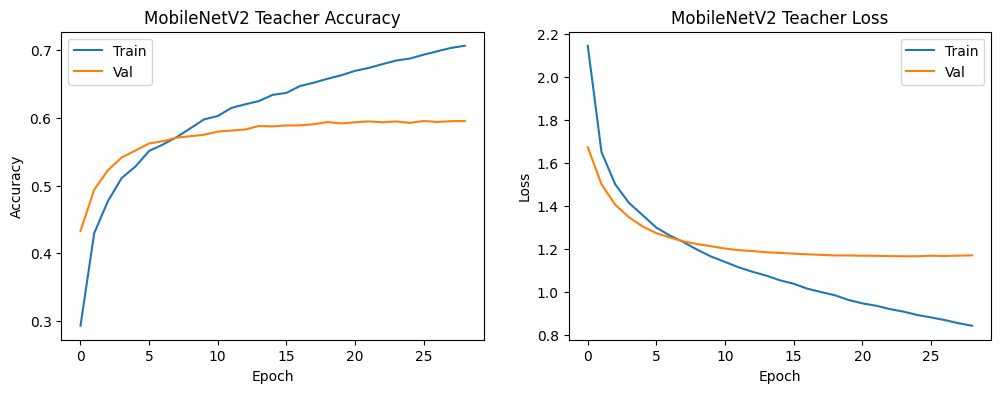

In [8]:
teacher_mobilenet = create_teacher_model(MobileNetV2, model_name="Teacher_MobileNetV2")
teacher_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = teacher_mobilenet.fit(
    x_train, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping]
)

plot_history(history_mobilenet, "MobileNetV2 Teacher")


### 📊 Evaluate Models

In [9]:
student_acc = student_model.evaluate(x_test, y_test_cat, verbose=0)[1]
vgg_acc = teacher_vgg16.evaluate(x_test, y_test_cat, verbose=0)[1]
mobilenet_acc = teacher_mobilenet.evaluate(x_test, y_test_cat, verbose=0)[1]

print(f"Student Accuracy:       {student_acc:.4f}")
print(f"VGG16 Teacher Accuracy: {vgg_acc:.4f}")
print(f"MobileNetV2 Accuracy:   {mobilenet_acc:.4f}")


Student Accuracy:       0.6463
VGG16 Teacher Accuracy: 0.6083
MobileNetV2 Accuracy:   0.5955


In [ ]:
student_baseline = create_student_model()
student_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
student_baseline.fit(x_train, y_train_cat, validation_split=0.1, epochs=10, verbose=0)

In [ ]:
teacher_mv3 = create_teacher_model(MobileNetV2)
teacher_vgg = create_teacher_model(VGG16)

teacher_mv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
teacher_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

teacher_mv3.fit(x_train, y_train_cat, validation_split=0.1, epochs=10, verbose=0)
teacher_vgg.fit(x_train, y_train_cat, validation_split=0.1, epochs=10, verbose=0)

In [ ]:
# MobileNetV3 (simulated)
student_mv3 = create_student_model()
distiller_mv3 = Distiller(student_mv3, teacher_mv3)
distiller_mv3.compile(optimizer='adam', metrics=['accuracy'],
                      student_loss_fn=CategoricalCrossentropy(),
                      distillation_loss_fn=KLDivergence(), alpha=0.1, temperature=10)
distiller_mv3.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, verbose=0)

# Both (average)
student_avg = create_student_model()
distiller_avg = Distiller(student_avg, [teacher_mv3, teacher_vgg])
distiller_avg.compile(optimizer='adam', metrics=['accuracy'],
                      student_loss_fn=CategoricalCrossentropy(),
                      distillation_loss_fn=KLDivergence(), alpha=0.1, temperature=10)
distiller_avg.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, verbose=0)

# Both (sequential)
student_seq = create_student_model()
distiller_seq1 = Distiller(student_seq, teacher_mv3)
distiller_seq1.compile(optimizer='adam', metrics=['accuracy'],
                       student_loss_fn=CategoricalCrossentropy(),
                       distillation_loss_fn=KLDivergence(), alpha=0.1, temperature=10)
distiller_seq1.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=5, verbose=0)

distiller_seq2 = Distiller(student_seq, teacher_vgg)
distiller_seq2.compile(optimizer='adam', metrics=['accuracy'],
                       student_loss_fn=CategoricalCrossentropy(),
                       distillation_loss_fn=KLDivergence(), alpha=0.1, temperature=10)
distiller_seq2.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=5, verbose=0)


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluate all models to fetch accuracy values
acc_scratch = student_baseline.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_mv3_teacher = teacher_mv3.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_vgg_teacher = teacher_vgg.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_mv3 = distiller_mv3.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_avg = distiller_avg.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_seq = distiller_seq2.evaluate(x_test, y_test_cat, verbose=0)[1]


labels = [
    'Student (Scratch)', 
    'Teacher (MobileNetV3)', 
    'Teacher (VGG16)', 
    'Student (Distilled by MobileNetV3)',
    'Student (Distilled by both teacher (average))',
    'Student (Distilled by both teacher (sequential))'
]

accuracies = [
    student_acc,
    teacher_mv3.evaluate(x_test, y_test_cat, verbose=0)[1],
    teacher_vgg.evaluate(x_test, y_test_cat, verbose=0)[1],
    acc_mv3,
    acc_avg,
    acc_seq
]

# Create DataFrame
df = pd.DataFrame({"Model": labels, "Accuracy": accuracies})

# Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Model"], df["Accuracy"], color='skyblue', edgecolor='black')

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.title("Final Accuracy Comparison of All 6 Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


NameError: name 'student_baseline' is not defined

## ✅ Final Model Evaluations and Accuracy Comparison

In [ ]:
# Evaluate all models to fetch accuracy values
acc_scratch = student_baseline.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_mv3_teacher = teacher_mv3.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_vgg_teacher = teacher_vgg.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_mv3 = distiller_mv3.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_avg = distiller_avg.evaluate(x_test, y_test_cat, verbose=0)[1]
acc_seq = distiller_seq2.evaluate(x_test, y_test_cat, verbose=0)[1]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

labels = [
    'Student (Scratch)', 
    'Teacher (MobileNetV3)', 
    'Teacher (VGG16)', 
    'Student (Distilled by MobileNetV3)',
    'Student (Distilled by both teacher (average))',
    'Student (Distilled by both teacher (sequential))'
]

accuracies = [
    acc_scratch,
    acc_mv3_teacher,
    acc_vgg_teacher,
    acc_mv3,
    acc_avg,
    acc_seq
]

# Create DataFrame
df = pd.DataFrame({"Model": labels, "Accuracy": accuracies})

# Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Model"], df["Accuracy"], color='cornflowerblue', edgecolor='black')

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.title("Final Accuracy Comparison of All 6 Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
